<a href="https://colab.research.google.com/github/epogrebnyak/rides-minimal/blob/master/rides_minimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
import pathlib
from dataclasses import dataclass
from typing import List, Tuple, Generator, Callable

import requests
import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist

pd.set_option("mode.chained_assignment", None)

# Подготовка данных

In [126]:
sample_data_url = "https://ridesample.s3.eu-central-1.amazonaws.com/one_day.zip"
sample_data_filename = "one_day.zip"

In [127]:
# Сохраним файл с данными локально
file = pathlib.Path(sample_data_filename)
if not file.exists():
  r = requests.get(sample_data_url)
  file.write_bytes(r.content)

In [128]:
# Функции для импорта данных

def get_dataframe(filename=sample_data_filename):
    df = pd.read_csv(filename, parse_dates=["time"])
    return check_dataframe(df)

def check_dataframe(df: pd.DataFrame):
    required_columns = set(["car", "lat", "lon", "time"])
    missing_columns = required_columns - set(df.columns)
    if missing_columns:
        raise ValueError(f"Missing from {df.head()}: {missing_columns}")
    return df   

# Вспомогательные функции

## Комбинации из n по 2

In [129]:
from itertools import combinations

def get_combinations(n: int) -> List[Tuple[int, int]]:
    """Выбор комбинаций из n по 2."""
    return [(i, j) for i, j in combinations(range(n), 2)]

def count_combinations(n: int) -> int:
    return len(list(get_combinations(n)))

## Функции расстояний

In [130]:
from geopy.distance import great_circle

def distance_km(a: tuple, b: tuple):
    # great_circle() менее точен, но быстрее чем geopy.distance.distance
    # https://geopy.readthedocs.io/en/stable/#module-geopy.distance
    return great_circle(a, b).km

Coord = Tuple[float, float]

# используется с distance_delta
def safe_distance(a: Coord, b: Coord) -> float:
  if not isinstance(b, tuple): # catch NaN
    return 0
  if a == b:
    return 0  
  return round(distance_km(a, b), 9)  

# используется с cdist
def safe_distance_2(a: Coord, b: Coord) -> float:    
    x1, y1 = a
    x2, y2 = b
    if np.isnan(x1) or np.isnan(x2):
        return np.nan
    else:
        return round(distance_km(a, b), 9)

def distance_delta(df: pd.DataFrame) -> pd.DataFrame:
    return (df.assign(prev_coord=lambda df: df.coord.shift(1))
              .apply(lambda df: safe_distance(df.coord, df.prev_coord), axis=1)
              )

In [131]:
# test
ex = pd.DataFrame({'coord': 
 {0: (54.683064, 20.497738),
  1: (54.683064, 20.497738),
  2: (54.683048, 20.49774),
  3: (54.683048, 20.49774),
  4: (54.68299200000001, 20.49775)}})
assert distance_delta(ex).to_dict() == {0: 0.0, 1: 0.0, 2: 0.00178376, 3:0, 4: 0.006260016}

## Кэширование длинных расчетов


In [132]:
def from_cache(filename, getter):
  import json, os  
  if os.path.exists(filename):
    with open(filename, "r") as f:
        return json.load(f)
  else:     
    content = getter()
    with open(filename, "w") as f:
        json.dump(content, f)
    return content

# Поиск сходимости

## Базовая работа с треком

In [133]:
class Route(pd.DataFrame):
    pass

def make_route(df: pd.DataFrame) -> Route:
    res = df[["time", "lat", "lon"]]
    res["coord"] = coord(df)
    return res.sort_values("time")

def make_route_full(df: pd.DataFrame) -> Route:
    res = make_route(df)
    # add time and dist deltas (slow)
    res['milage'] = milage_acc(res)
    res['duration'] = duration_acc(res)
    return res

def get_cars_and_routes(df: pd.DataFrame) -> (List[str], List[Route]):
    cars = []
    routes = []
    df["date"] = df["time"].apply(lambda x: x.date())
    for date in df.date.unique():
        for car in df.car.unique():
            ix = (df.car == car) & (df.date == date)
            cars.append(car)
            route = make_route(df[ix])
            routes.append(route)
    return cars, routes     


def coord(df: pd.DataFrame):
    return list(zip(df.lat, df.lon))


def seconds(series: pd.Series) -> pd.Series:
    return series.apply(lambda x: x.total_seconds())


def duration_acc(df: pd.DataFrame) -> pd.DataFrame:
    return seconds(df.time - df.time.iloc[0]) / 60


def time_deltas(df: pd.DataFrame) -> pd.DataFrame:
    return seconds(df.time.diff())


def milage_acc(df: pd.DataFrame) -> pd.DataFrame:
    return distance_delta(df).cumsum().fillna(0)


def milage(route) -> float:
    return round(milage_acc(route).iloc[-1], 2)


def points(route_df: Route) -> np.ndarray:
    return np.array(route_df.coord.to_list())


def date(route):
    return route.iloc[0].time.date()


def start_time(route):
    return route.iloc[0].time


def end_time(route):
    return route.iloc[-1].time

In [134]:
assert milage_acc(ex).to_dict() == {0: 0.0, 1: 0.0, 2: 0.00178376, 3: 0.00178376, 4: 0.008043776}

##  Функции апроксимации трека

- [x] по времени в пути (инкремент, количество сегментов)
- [x] по расстоянию (инкремент, количество сегментов)
- [ ] по астрономическому времени (есть в ноутбке `rides2`)
- [ ] по остановкам (есть в "тяжелом" алгоритме)

In [135]:
def growing_index(xs, step):
    xs = [x for x in xs]
    result = [0]  # will include start point
    current = xs[0]
    for i, x in enumerate(xs):
        accumulated = x - current
        if accumulated >= step:
            result.append(i)
            accumulated = 0
            current = x
    n = len(xs) - 1
    if result[-1] != n: # will include end point
        result.append(n)
    return result


def time_increment_(minutes: int, route: Route):
    xs = duration_acc(route)
    ix = growing_index(xs, minutes)
    return route.iloc[ix]


def time_increment(minutes):
    return lambda route: time_increment_(minutes, route)


def distance_increment_(step_km: float, route: Route):
    xs = milage_acc(route)
    ix = growing_index(xs, step_km)
    return route.iloc[ix]


def distance_increment(step_km: float):
    return lambda route: distance_increment_(step_km, route)


def find_index_quantile(xs: List, q: float) -> int:
    if q == 0:
        return 0
    if q == 1:
        return -1
    return np.searchsorted(xs, v=np.quantile(xs, q), side="left")


def find_index(xs: List, n_segments: int) -> List[int]:
    qs = np.linspace(0, 1, n_segments + 1)
    return [find_index_quantile(xs, q) for q in qs]


def n_segments_by_distance_(n: int, route: Route):
    xs = milage_acc(route)
    ix = find_index(xs, n)
    return route.iloc[ix]


def n_segments_by_distance(n: int):
    return lambda route: n_segments_by_distance_(n, route)


def n_segments_by_time_(n: int, route: Route):
    xs = duration_acc(route)
    ix = find_index(xs, n)
    return route.iloc[ix]


def n_segments_by_time(n: int):
    return lambda route: n_segments_by_time_(n, route)


In [136]:
assert n_segments_by_distance(2)(ex).index.to_list() == [0, 2, 4]

## Матрица расстояний между точками двух треков



In [137]:
def proximity(r1, r2):
    mat = cdist(points(r1), points(r2), safe_distance_2)
    return Proximity(mat)

#def report_proximity(route1: Route, route2: Route, radius_km: float):
#    p = proximity(route1, route2)
#    return p.report(radius_km)

@dataclass
class Proximity:
    """Матрица расстояний между двумя треками."""

    mat: np.ndarray

    def min(self):
        """
    Минимиальное расстояние между всеми точками двух треков.
    """
        return round(np.nanmin(self.mat), 3)

    def max(self):
        """
    Максимальное расстояние между всеми точками двух треков.
    """
        return round(np.amax(self.mat), 3)

    def side_min(self, axis: int):
        # 1 is to search by columns - applies to searching minima for 1st route
        # 0 is to search by rows - applies to searching minima for 2nd route
        x = np.nanmin(self.mat, axis)
        return x[~np.isnan(x)]

    def coverages(self):
        return Coverage(self.side_min(1)), Coverage(self.side_min(0))

    def report(self, search_radius: float):
      c1, c2 = self.coverages()
      return dict(
                min_dist=self.min(),
                max_dist=self.max(),
                cov_1=c1.coverage(search_radius),
                cov_2=c2.coverage(search_radius),
            )    


@dataclass
class Coverage:
    """Для каждой точки выбранного трека посчитано 
       минимальное из расстояний до точек другого трека.
       
       Если в треке 10 точек, то минимальных расстояний 
       до другого трека будет 10.
       
       Мы выбираем те из расстояний, которые меньше заданного 
       порога(радиуса) сближения.
              
       Предположим в треке 10 точек и минимальные расстояния до 
       фигуры второго трека такие:
       
       >> mins = [21.2, 22.6, 17.6, 7.7, 2.7, 0.3, 0.4, 0.6, 0.2, 3.1]
       
       Тогда "сблизившимися" с другим треков при радиусе точности 1 
       мы считаем 4 точки:
       
       >> radius = 1           
       >> [x for x in mins if x < radius]
       [0.3, 0.4, 0.6, 0.2]
       
       Коэффциент перекрытия составляет 4/10 = 40%. 
       
       Он показывает, что 40% точек данного трека
       находились на расстоянии не более чем *radius*
       от какой-то точки другого трека.
       
       Замечания:
       
       - Коэффциент перекрытия (КП) может интепретироваться как 
         часть пути, если отрезки между точками равные. 
         
       - Значение коэффциента перекрытия зависит от точности 
         апроксимации трека и радиуса.       
         
       - Треки могут иметь сложную форму, высокий КП не гарантирует,
         что доставку по одному треку можно переложить на другой трек.
         Но при низких КП это заведомо невозможно.
         
       - Нулевой КП - машины ездили в разных местах.  
         
    """

    mins: np.ndarray

    def in_proximity(self, radius: float):
        """Все минимальные расстояния до другого трека, величина 
          которых меньше заданного радиуса сближения.
       """
        return self.mins[self.mins < radius]

    def coverage(self, radius: float):
        """Коэффициент перекрытия - доля трека, которая находится 
           на расстоянии не более заданного радиуса от другого трека.
        """
        return round(len(self.in_proximity(radius)) / len(self.mins), 2)

## Функции поиска сходимости





In [138]:
def inspect(routes, simplify_with=distance_increment):
  def pair(i, j, search_radius, *arg, **kwarg):
      f = simplify_with(*arg, **kwarg)
      r1 = f(routes[i])
      r2 = f(routes[j])
      return proximity(r1, r2).report(search_radius)
  return pair

def search(
    routes: List[Route],
    simplify_with: Callable,
    search_radius_1: float,
    refine_with = Callable,
    search_radius_2 = float,
    limit=None,
):

    # Урезаем для демо-примеров
    if limit:
        routes = routes[0:limit]
        print(f"Trimmed dataset to {limit} pairs")

    m = len(routes)
    print(f"{count_combinations(m)} pairs are possible for {m} routes")

    # Грубая апроксимация треков    
    print(f"Simplified {m} routes")
    rough_routes = [simplify_with(route) for route in routes]

    def prox(i, j):  # замыкание для удобного доступа к routes
        return proximity(rough_routes[i], rough_routes[j])

    # Выбор пересекающися пар
    pairs = [(i,j) for (i,j) in get_combinations(m) 
              if prox(i,j).min() < search_radius_1]
    print(f"Found {len(pairs)} pairs of intersecting routes")

    # Уточняем апроксимацию треков   
    def members(pairs):
      from itertools import chain
      return set(chain.from_iterable(pairs))

    refined_routes = list(range(m)) 
    for k, i in enumerate(members(pairs)):
        refined_routes[i] = refine_with(routes[i])
    print(f"Made better approximation of {k} routes")
    print("Calculating distances between routes and reporting...")

    # Считаем перекрытие треков в пересекающися парах
    from tqdm import tqdm
    result = []
    for (i, j) in tqdm(pairs):
        p = proximity(refined_routes[i], refined_routes[j])
        if p.min() < search_radius_1:
            d = dict(
                id_1=i, 
                id_2=j,
                **p.report(search_radius_2)
            )
            result.append(d)
    return result

## Примеры

In [139]:
df = get_dataframe(sample_data_filename)  # Получаем исходные данные
cars, routes = get_cars_and_routes(df)    # Преобразуем датафрейм в список поедок
assert len(cars) == len(routes) == 49

In [140]:
# Пробег по поездкам
milages = from_cache("milage.json", lambda: [milage(r) for r in routes])  
assert milages[0] == 72.38

### Поиск близких пар

In [141]:
# Расчет попарных характеристик поездок

def default_search(routes: List[Route], limit=None):
   return search( 
    routes,
    simplify_with = n_segments_by_distance(n=10),
    search_radius_1 = 10,
    refine_with = distance_increment(step_km=2.5),
    search_radius_2 = 2.5 * 1.2,
    limit=limit,
)   
result_dicts = default_search(routes, limit=None)

1176 pairs are possible for 49 routes
Simplified 49 routes
Found 667 pairs of intersecting routes
Made better approximation of 48 routes
Calculating distances between routes and reporting...

100%|██████████| 667/667 [01:39<00:00,  9.95it/s]

In [142]:
  # Формируем выгрузку данных в csv
  
def overlap(df):
    return ((df.cov_1*df.len_1 + df.cov_2*df.len_2)
               .divide(df.len_1+df.len_2)
               .round(2)
               )

def add_vars(df, km = lambda i: milages[i]):
    return (df.assign(cov=lambda df: df.cov_1 + df.cov_2)
              .assign(len_1=lambda df: df.id_1.apply(km))
              .assign(len_2=lambda df: df.id_2.apply(km)) 
              .assign(op=overlap)
      )

result_df = (
      add_vars(pd.DataFrame(result_dicts))
      .sort_values("cov", ascending=False)
      .head(20)
      .reset_index(drop=True)
  )  
result_df.to_csv("output.csv", index=None)
result_df

,id_1,id_2,min_dist,max_dist,cov_1,cov_2,cov,len_1,len_2,op
0,24,39,0.014,87.724,1.00,1.00,2.00,207.66,193.86,1.00
1,4,42,0.018,9.505,1.00,1.00,2.00,88.24,71.92,1.00
2,19,39,0.015,87.049,1.00,1.00,2.00,234.98,193.86,1.00
3,23,32,0.003,5.311,1.00,1.00,2.00,25.74,48.77,1.00
4,19,24,0.017,87.453,0.99,1.00,1.99,234.98,207.66,0.99
5,4,17,0.065,9.437,1.00,0.97,1.97,88.24,78.81,0.99
6,17,42,0.065,9.527,0.97,1.00,1.97,78.81,71.92,0.98
7,10,30,0.048,9.269,1.00,0.96,1.96,40.66,62.88,0.98
8,32,46,0.006,6.274,0.95,1.00,1.95,48.77,27.98,0.97
9,24,38,0.021,87.508,1.00,0.95,1.95,207.66,619.64,0.96


### Рисуем одну пару

In [143]:
pair = inspect(routes, distance_increment)

In [144]:
pair(i=32, j=46, search_radius=1, step_km=1)

def f(k):
  d = pair(32, 46, k, k)
  d.update(dict(radius=k, id_1=32, id_2=36))
  return d
z = add_vars(pd.DataFrame([f(k) for k in [0.025, 0.050, 0.100, 0.500, 1, 2.5, 5]]))
z

,min_dist,max_dist,cov_1,cov_2,radius,id_1,id_2,cov,len_1,len_2,op
0,0.000,7.267,0.39,0.51,0.025,32,36,0.90,48.77,167.1,0.48
1,0.000,7.265,0.45,0.52,0.050,32,36,0.97,48.77,167.1,0.50
2,0.001,7.260,0.49,0.59,0.100,32,36,1.08,48.77,167.1,0.57
3,0.005,7.271,0.77,0.68,0.500,32,36,1.45,48.77,167.1,0.70
4,0.012,7.089,0.83,0.79,1.000,32,36,1.62,48.77,167.1,0.80
5,0.006,6.274,0.90,1.00,2.500,32,36,1.90,48.77,167.1,0.98
6,0.020,5.688,1.00,1.00,5.000,32,36,2.00,48.77,167.1,1.00


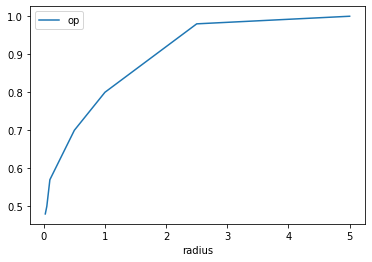

In [145]:
z.plot(x='radius', y='op')

# Графические функции

In [146]:
"""Графические функции для отрисовки треков"""

import matplotlib.pyplot as plt
from matplotlib import cm


def get_color(i, n):
    if n <= 10:
        cmap = cm.get_cmap(name="tab10")
        return cmap(i)
    else:
        cmap = cm.get_cmap(name="jet")
        return cmap(i / n)


def yield_route_and_color(routes):
    n = len(routes)
    for i, r in enumerate(routes):
        col = get_color(i, n)
        yield r, col


def make_plotter(axis_plotter_func):
    def plotter(routes, ax=None, title=""):
        if ax is None:
            f, ax = plt.subplots()
        n = len(routes)
        for i, r in enumerate(routes):
            col = get_color(i, n)
            axis_plotter_func(ax, r, col)
        ax.set_title(title)
        return ax

    return plotter


def scatter(ax, route, col):
    ax.scatter(x=route.lon, y=route.lat, s=0.5, alpha=0.8, color=col)


def segments(ax, route, col):
    ax.plot(route.lon, route.lat, lw=1, alpha=0.8, linestyle=":", color=col)


plot_points = make_plotter(scatter)
plot_connections = make_plotter(segments)


def plot_points_and_connections(routes, title="", ax=None):
    ax = plot_points(routes, ax)
    plot_connections(routes, ax)


def plot_raw_and_reduced(f1, f2, r1, r2, title="Общий заголовок"):
    fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2, figsize=(10, 4), sharex=True, sharey=True
    )
    plot_points_and_connections([f1, f2], ax=ax1, title="Исходные треки")
    plot_points_and_connections([r1, r2], ax=ax2, title="Упрощенные треки")
    plt.suptitle(title)


def plot_two(routes, i: int, j: int, simplify_with=None, title=""):
    """Отрисовка пары маршрутов по индексам в выборке."""
    f1, f2 = routes[i], routes[j]
    if simplify_with:
        r1, r2 = simplify_with(f1), simplify_with(f2)
    else:
        r1, r2 = f1, f2
    title = f"Поездки {i} и {j}"
    plot_raw_and_reduced(f1, f2, r1, r2, title)


def plot_one(route):      
    return plot_points([route])
            

## Пример

(48.77, 27.98)

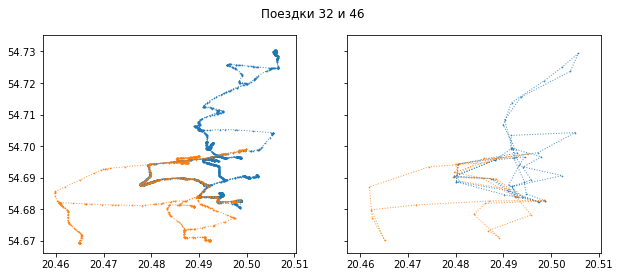

In [147]:
plot_two(routes, 32, 46, distance_increment(1))
milages[32], milages[46]